# Liesel-GAM Demo Notebook

## Setup and Imports

In [24]:
import jax
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [25]:
rng = np.random.default_rng(1)
x = rng.uniform(-2, 2, 200)

log_sigma = -0.2 * x
mu = -x + x**2
y = mu + jnp.exp(log_sigma) * rng.normal(0.0, 1.0, 200)

df = pd.DataFrame({"y": y, "x": x})

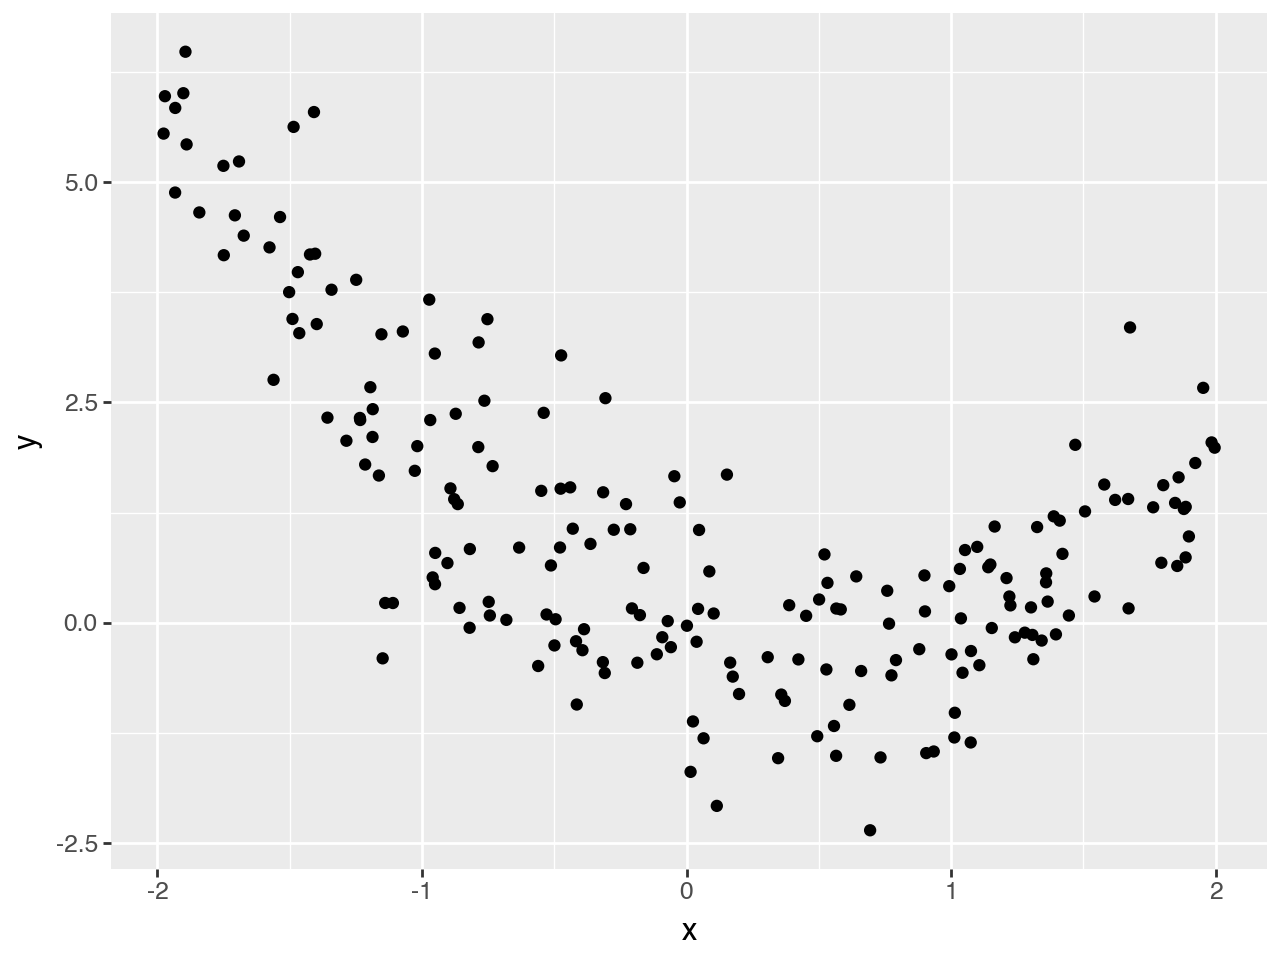

In [26]:
(p9.ggplot(df) + p9.geom_point(p9.aes("x", "y")))

## Model Definition

### Setup response model

In [27]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.y.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [28]:
tb = gam.TermBuilder.from_df(df)

In [29]:
loc += tb.lin("x + {x**2}")
scale += tb.lin("x")

### Build and plot model

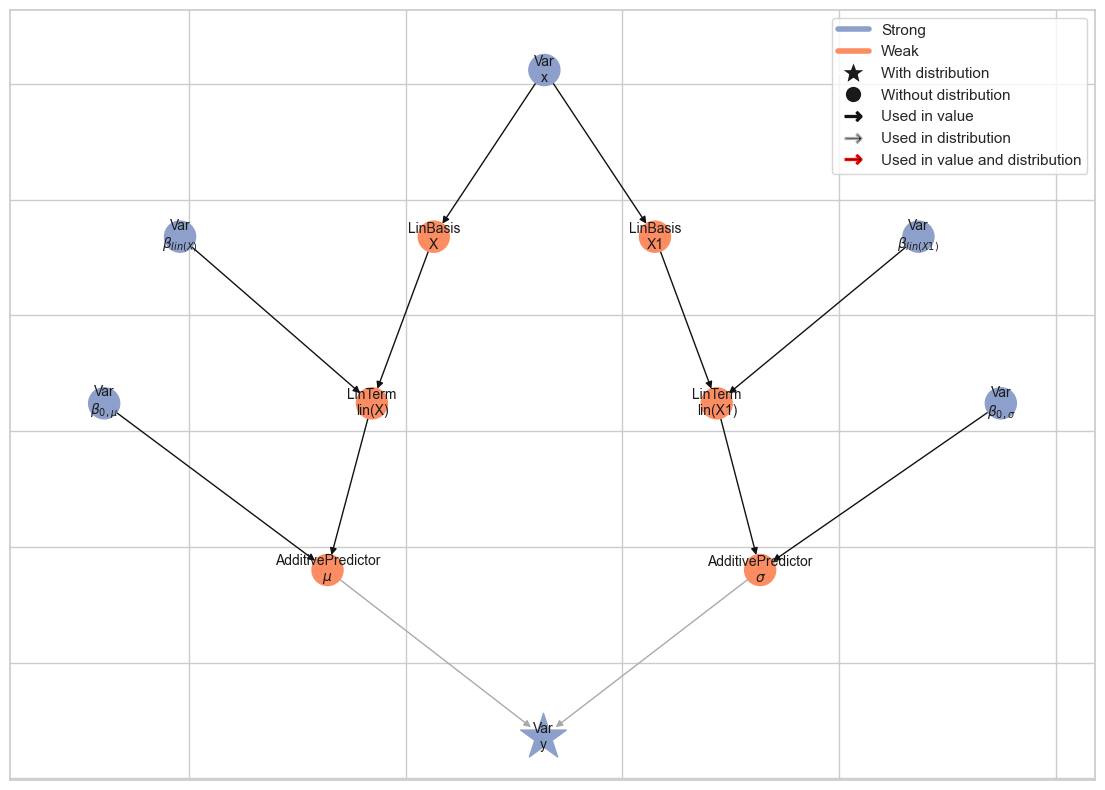

In [30]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [31]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{lin(X1)}$', '$\\beta_{0,\\mu}$', '$\\beta_{lin(X)}$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:03<00:00,  5.14chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1174.55chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1601.49chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO

### MCMC summary

In [32]:
summary = gs.Summary(results)
summary

Parameter summary:

                             kernel      mean        sd    q_0.05     q_0.5  \
parameter          index                                                      
$\beta_{0,\mu}$    ()     kernel_02 -0.119205  0.095312 -0.281637 -0.117928   
$\beta_{0,\sigma}$ ()     kernel_00 -0.100343  0.050661 -0.183603 -0.101215   
$\beta_{lin(X)}$   (0,)   kernel_03 -1.027162  0.062181 -1.128821 -1.027971   
                   (1,)   kernel_03  1.031799  0.057191  0.938291  1.032361   
$\beta_{lin(X1)}$  (0,)   kernel_01 -0.139596  0.050307 -0.223432 -0.139673   

                            q_0.95  sample_size     ess_bulk     ess_tail  \
parameter          index                                                    
$\beta_{0,\mu}$    ()     0.037920         4000  3439.286243  3849.618131   
$\beta_{0,\sigma}$ ()    -0.014597         4000  3603.724769  3926.464734   
$\beta_{lin(X)}$   (0,)  -0.924272         4000  3721.232482  3536.985110   
                   (1,)   1.125323         4000  3298.053944  3373.149239   
$\beta_{lin(X1)}$  (0,)  -0.057577         4000  4055.052645  3757.046840   

                              rhat  
parameter          index            
$\beta_{0,\mu}$    ()     1.001085  
$\beta_{0,\sigma}$ ()     1.000497  
$\beta_{lin(X)}$   (0,)   1.000276  
                   (1,)   1.000673  
$\beta_{lin(X1)}$  (0,)   1.000528

### MCMC trace plots

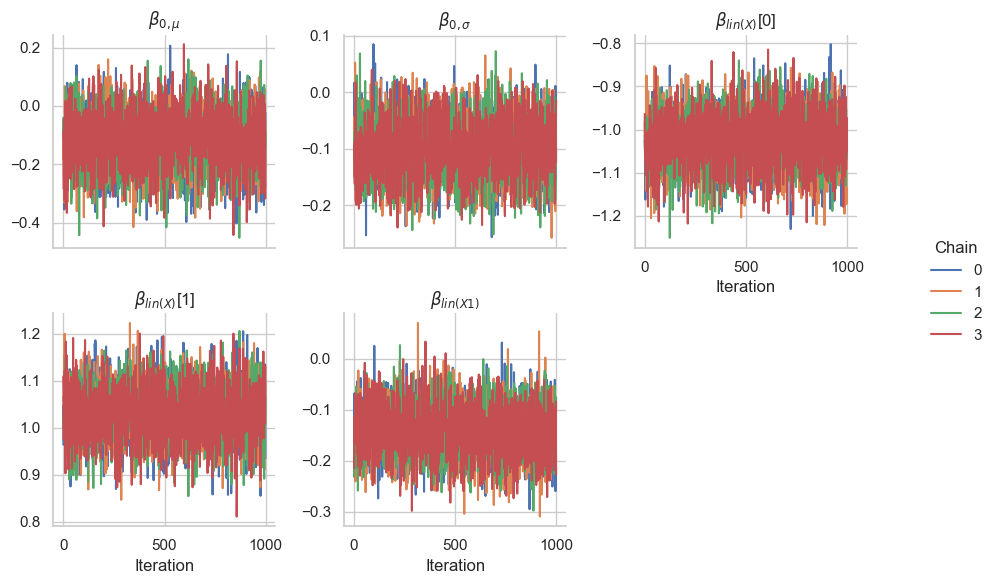

In [33]:
gs.plot_trace(results)

## Predictions

In [34]:
samples = results.get_posterior_samples()

### Predict variables at new x values

In [35]:
x_grid = jnp.linspace(x.min(), x.max(), 300)
predictions = model.predict(
    samples=samples,
    predict=["lin(X)", "lin(X1)", "$\\mu$", "$\\sigma$"],
    newdata={"x": x_grid},
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)
predictions_summary["x"] = np.tile(x_grid, len(predictions))

In [36]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,ess_bulk,ess_tail,mcse_mean,mcse_sd,rhat,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,x
0,$\mu$,$\mu$[0],"(0,)",4000,5.942781,0.062145,0.249289,3496.654672,3818.162581,0.004206,0.002797,0.999963,5.524903,5.946890,6.361986,5.508290,6.336629,-1.976702
1,$\mu$,$\mu$[1],"(1,)",4000,5.875115,0.060636,0.246244,3500.481968,3857.890761,0.004152,0.002763,0.999958,5.461788,5.879310,6.288025,5.455672,6.273677,-1.963415
2,$\mu$,$\mu$[2],"(2,)",4000,5.807824,0.059158,0.243225,3503.729095,3710.956167,0.004099,0.002729,0.999956,5.399700,5.811352,6.217121,5.387421,6.195852,-1.950128
3,$\mu$,$\mu$[3],"(3,)",4000,5.740884,0.057710,0.240229,3508.850914,3972.487657,0.004046,0.002696,0.999949,5.337867,5.744282,6.144596,5.325035,6.123663,-1.936841
4,$\mu$,$\mu$[4],"(4,)",4000,5.674308,0.056292,0.237260,3514.257567,4030.142825,0.003994,0.002663,0.999945,5.275557,5.677718,6.072834,5.262672,6.052126,-1.923554


### Plot fitted functions

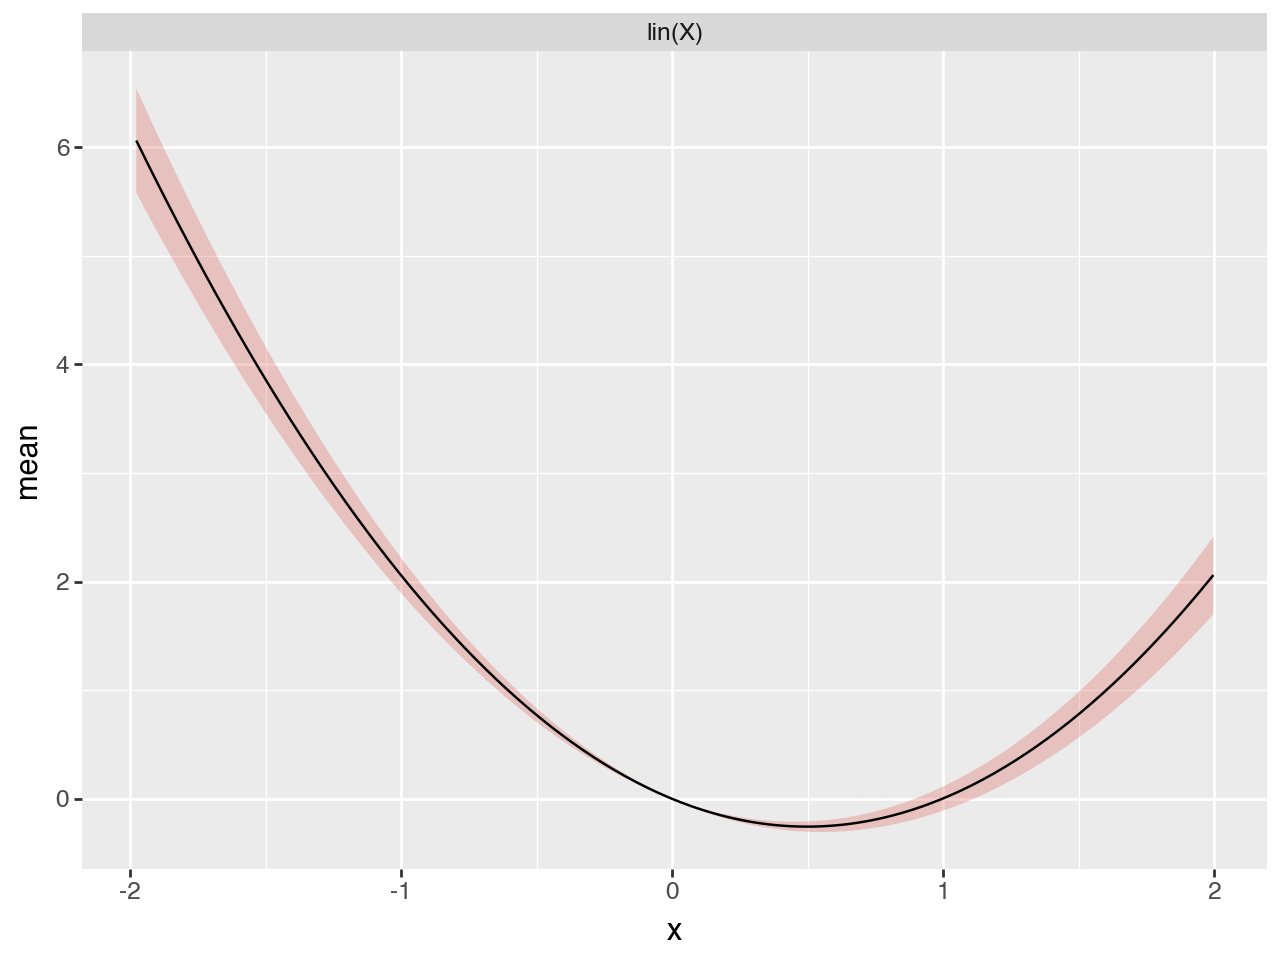

In [37]:
select = predictions_summary["variable"].isin(["lin(X)", "lin(X2)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot parameters as functions of covariate

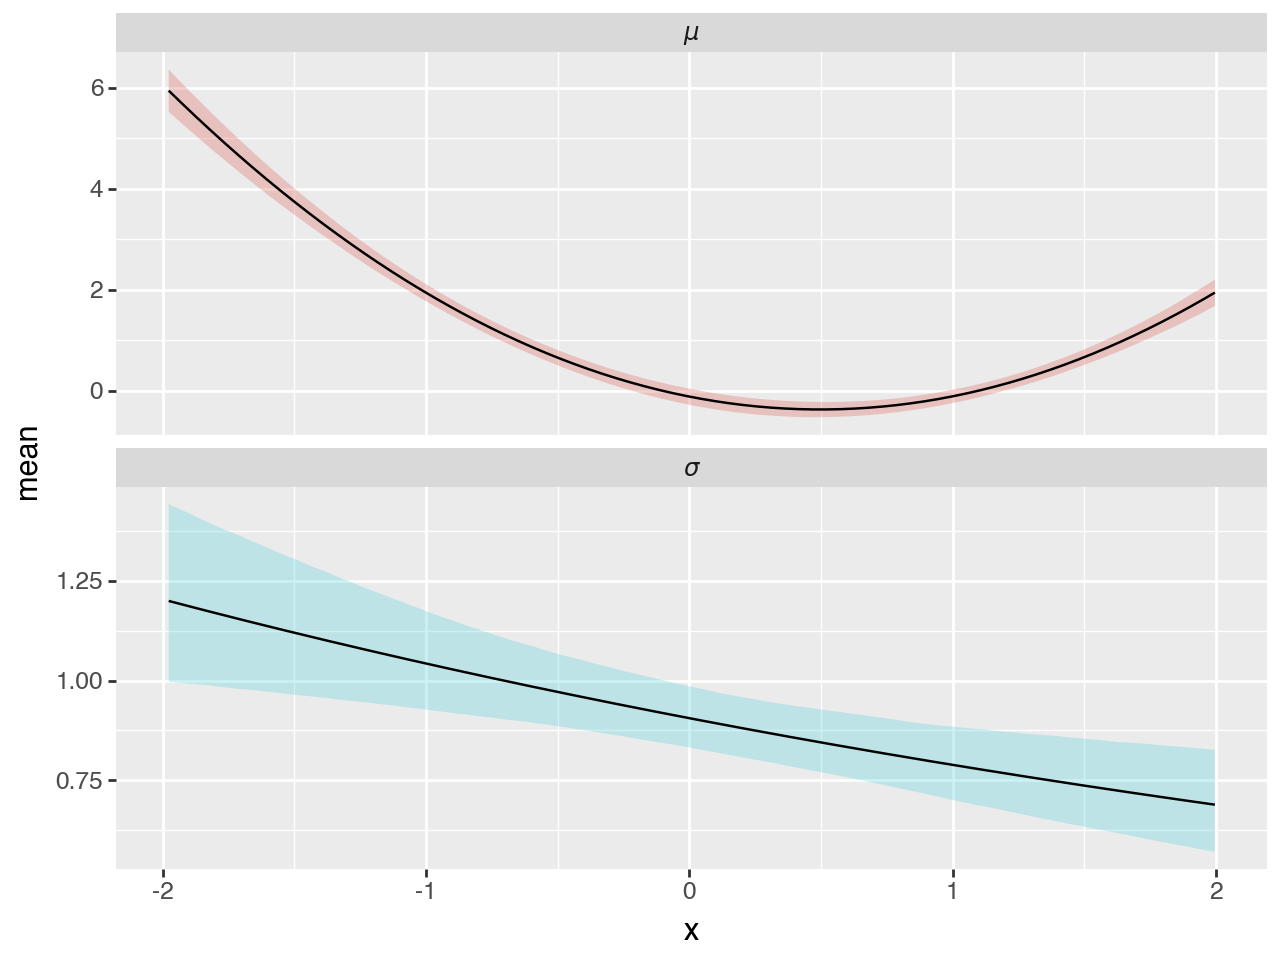

In [38]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot mean function with data

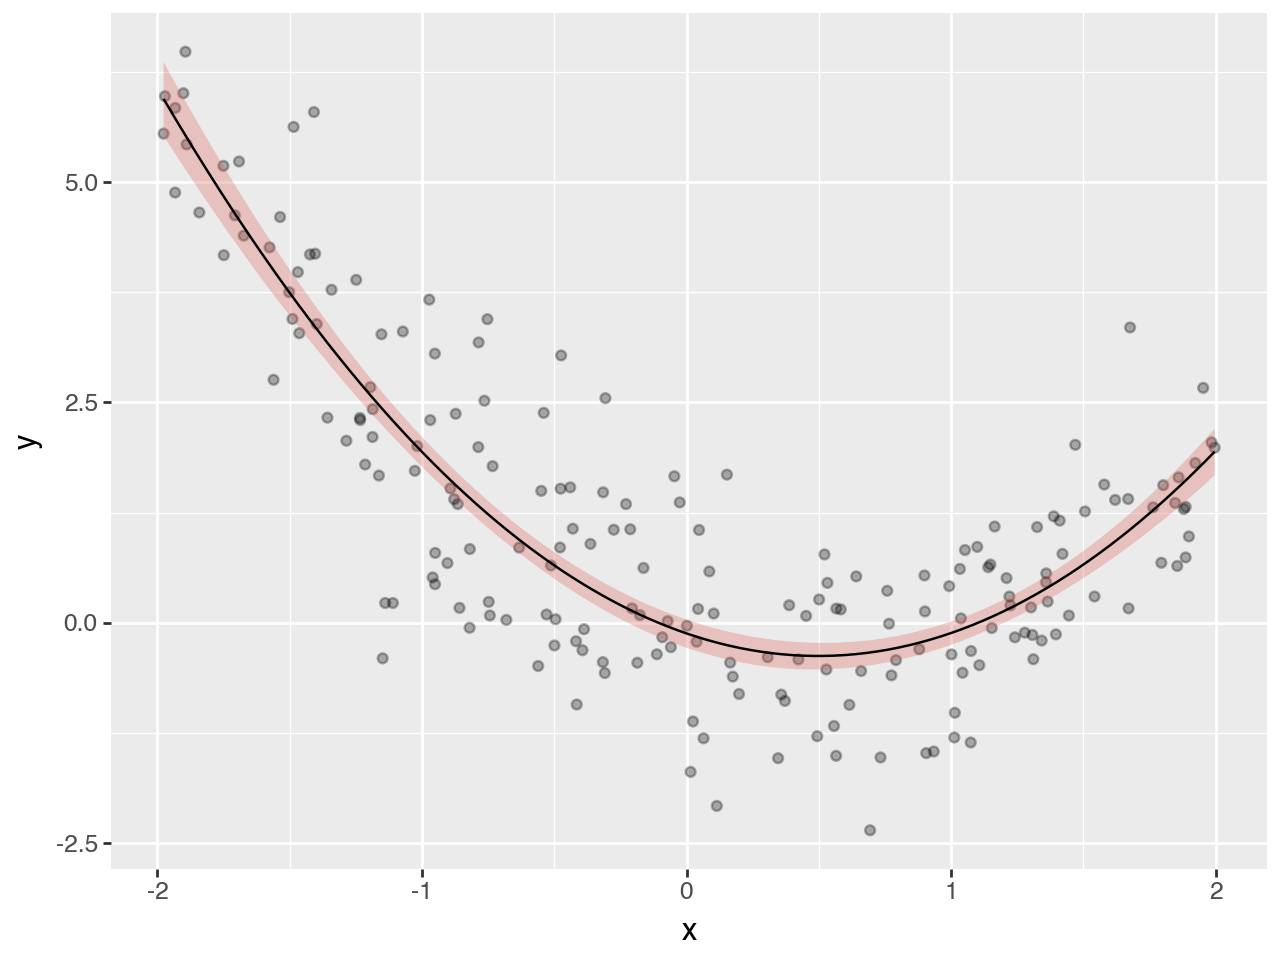

In [39]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.guides(fill="none")
)

### Plot average posterior predictive distribution

In [40]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
mu_sigma_df = (
    predictions_summary[select][["variable", "mean", "x"]]
    .pivot(index="x", columns=["variable"], values="mean")
    .reset_index()
)

mu_sigma_df["low"] = mu_sigma_df["$\\mu$"] - mu_sigma_df["$\\sigma$"]
mu_sigma_df["high"] = mu_sigma_df["$\\mu$"] + mu_sigma_df["$\\sigma$"]
mu_sigma_df

variable,x,$\mu$,$\sigma$,low,high
0,-1.976702,5.942781,1.199483,4.743299,7.142264
1,-1.963415,5.875115,1.197180,4.677935,7.072296
2,-1.950128,5.807824,1.194883,4.612941,7.002707
3,-1.936841,5.740884,1.192590,4.548294,6.933474
4,-1.923554,5.674308,1.190301,4.484007,6.864609
...,...,...,...,...,...
295,1.942956,1.780181,0.693835,1.086346,2.474016
296,1.956243,1.819993,0.692594,1.127399,2.512588
297,1.969530,1.860165,0.691355,1.168810,2.551521
298,1.982817,1.900702,0.690120,1.210582,2.590822


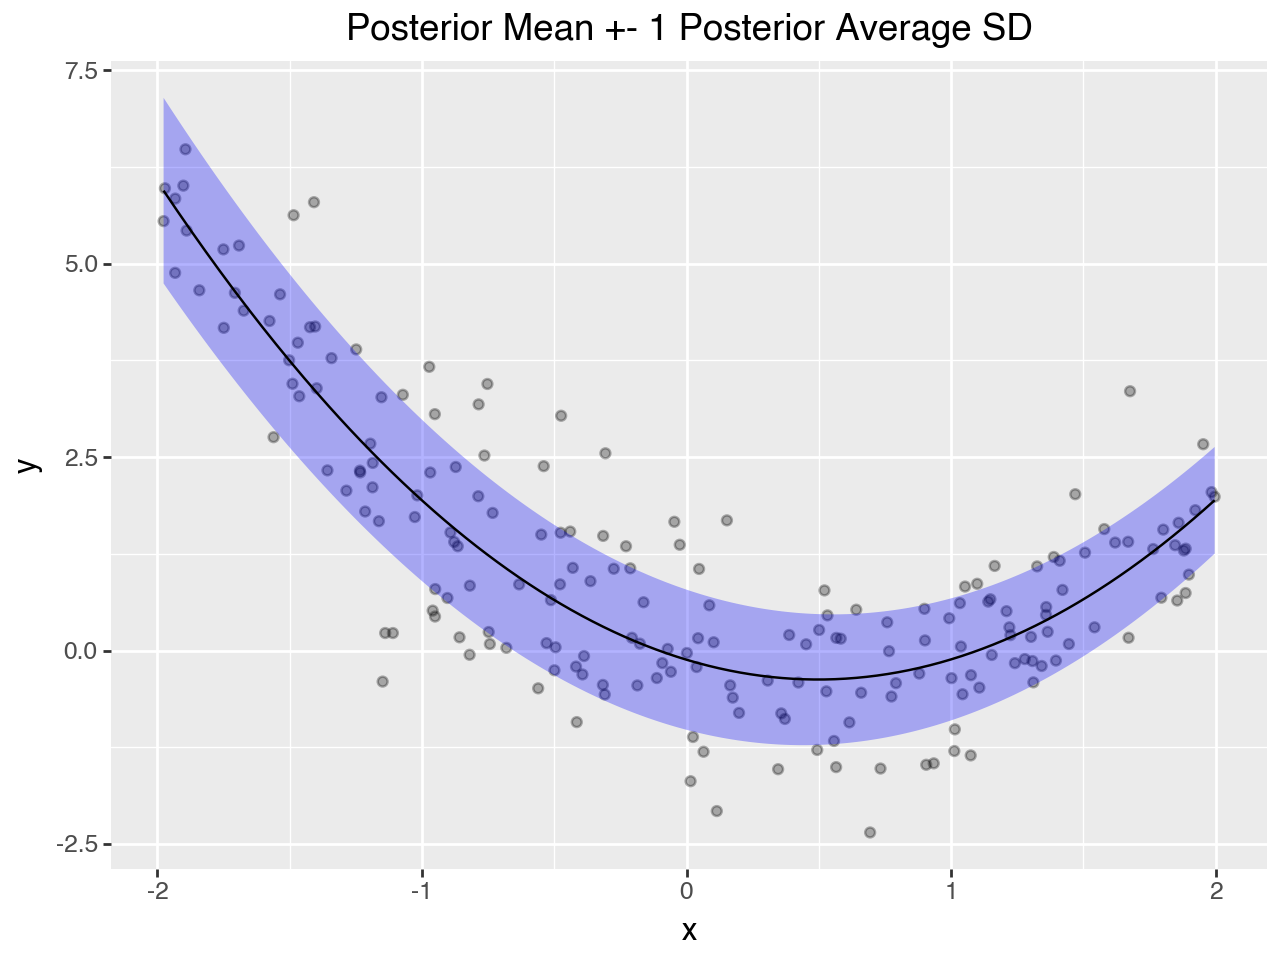

In [41]:
(
    p9.ggplot()
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="low", ymax="high"),
        alpha=0.3,
        fill="blue",
        data=mu_sigma_df,
    )
    + p9.geom_line(p9.aes("x", "$\\mu$"), data=mu_sigma_df)
    + p9.labs(title="Posterior Mean +- 1 Posterior Average SD")
    + p9.guides(fill="none")
)

## Posterior Predictive Checks

### Draw posterior predictive samples

In [42]:
ppsamples = model.sample(
    shape=(3,), seed=jax.random.key(1), posterior_samples=samples
)

ppsamples["y"].shape

(3, 4, 1000, 200)

In [43]:
# can be reshaped to concatenate the first two axes
_ = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])

### Summarize posterior predictive samples

In [44]:
ppsamples = model.sample(
    shape=(),  # just draw 1 value for each posterior sample
    seed=jax.random.key(1),
    posterior_samples=samples,
)

# summarise ppsamples
ppsamples_summary = gs.SamplesSummary(ppsamples).to_dataframe().reset_index()

# add covariate to df
ppsamples_summary["x"] = df["x"].to_numpy()

### Plot posterior predictive summary

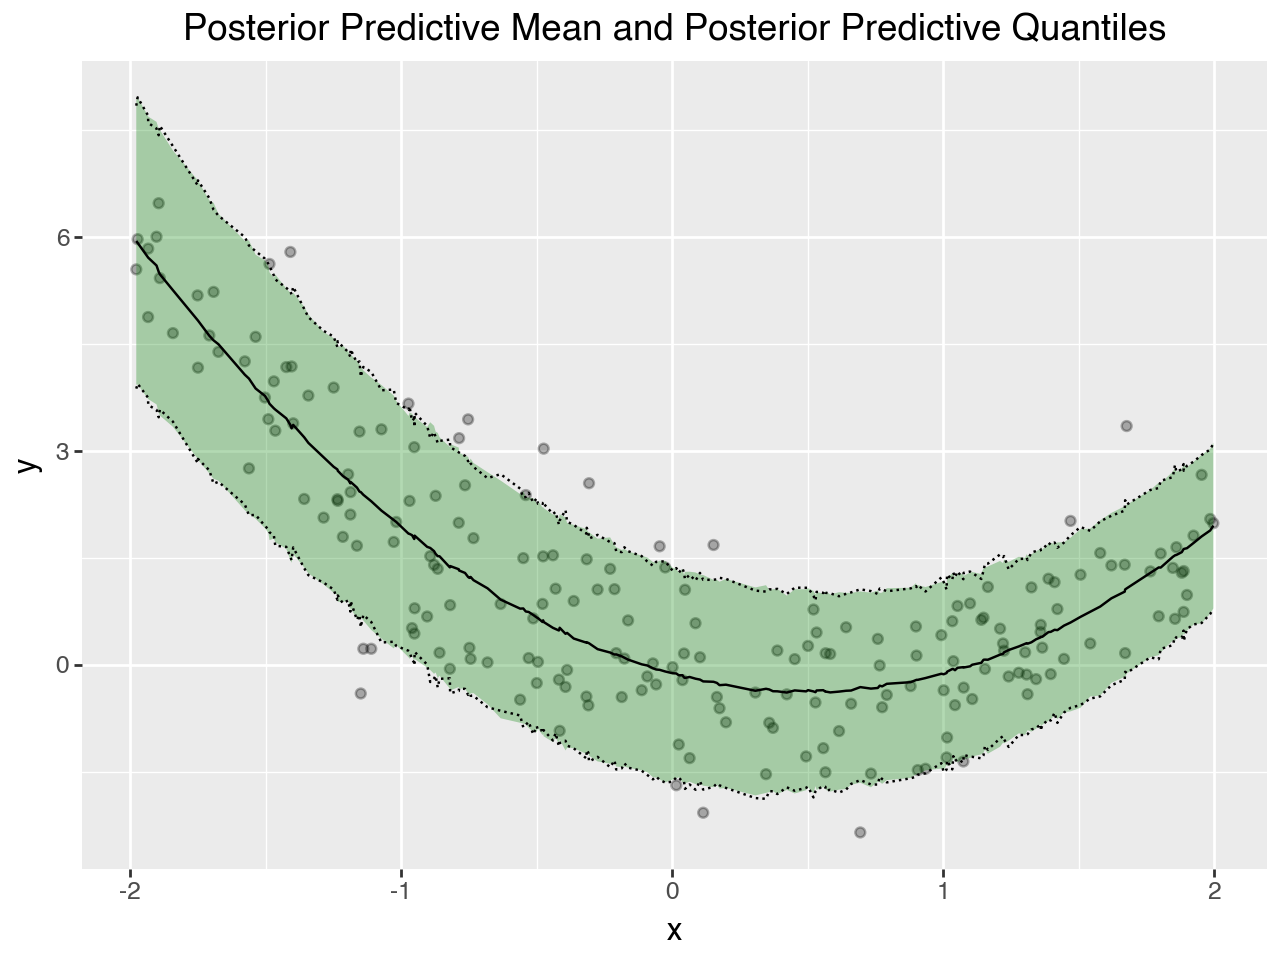

In [45]:
(
    p9.ggplot(ppsamples_summary)
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
    )
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.labs(title="Posterior Predictive Mean and Posterior Predictive Quantiles")
    + p9.guides(fill="none")
)

### Plot posterior predictive samples

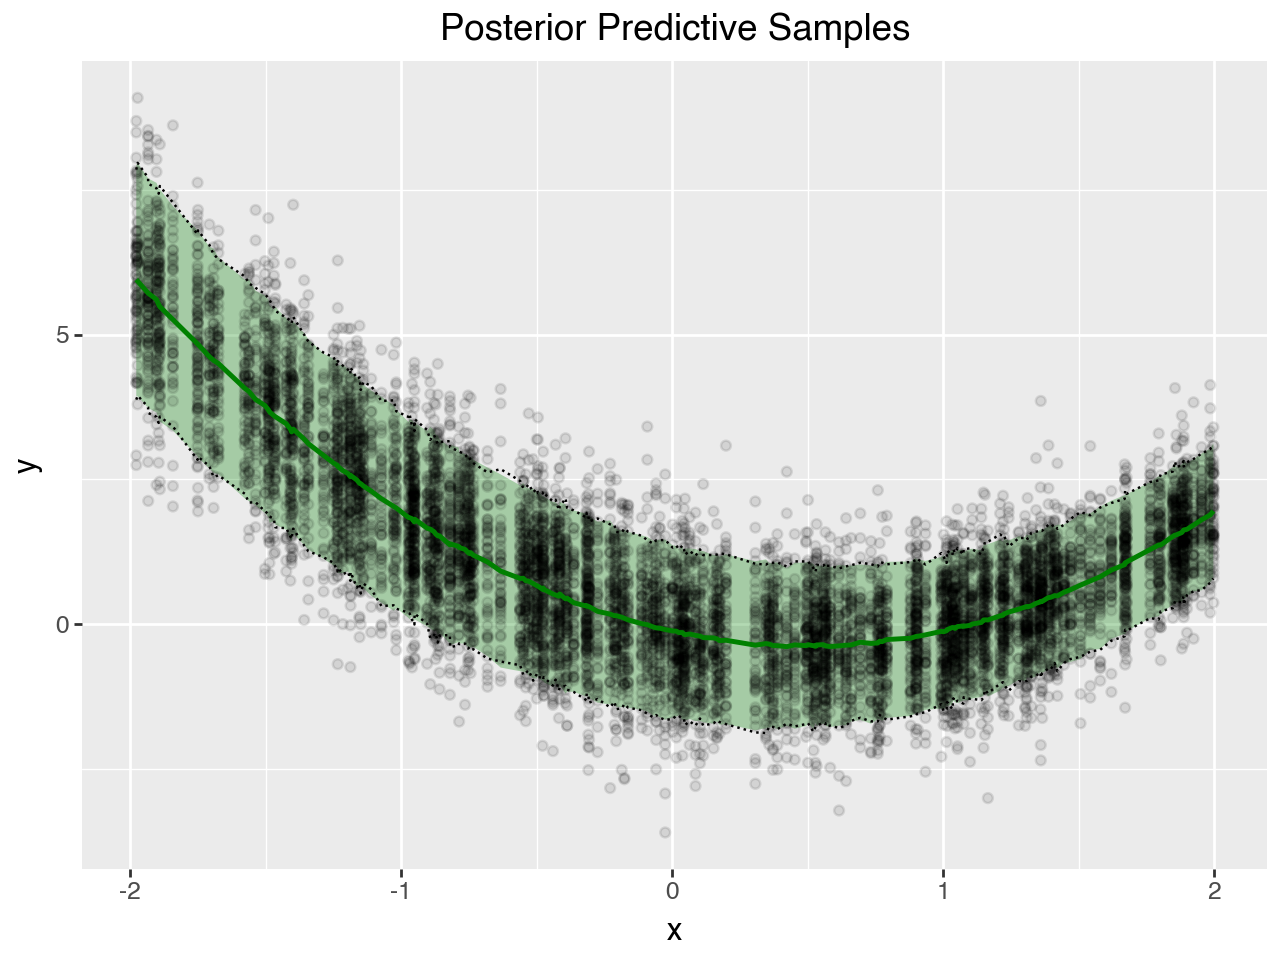

In [46]:
ppsamples_reshaped = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])
ppsamples_df = pd.DataFrame(ppsamples_reshaped.T)
ppsamples_df["x"] = df["x"].to_numpy()
ppsamples_df = ppsamples_df.melt(id_vars=["x"], value_name="y", var_name="sample")
ppsamples_df[ppsamples_df["sample"].isin(range(5))]


nsamples = 50


(
    p9.ggplot(ppsamples_df[ppsamples_df["sample"].isin(range(nsamples))])
    + p9.labs(title="Posterior Predictive Samples")
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
        data=ppsamples_summary,
    )
    + p9.geom_point(p9.aes("x", "y"), alpha=0.1)
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "mean"), color="green", size=1, data=ppsamples_summary)
)